In [93]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [94]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [95]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

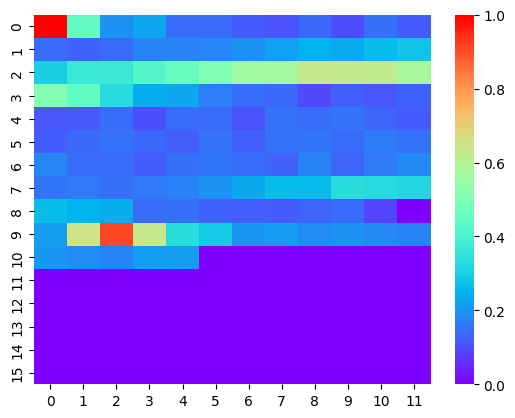

In [96]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [97]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [98]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [99]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [100]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [101]:
from src import models
config = {
    'hidden' : 16,
    'num_layers' : 1,
    'num_classes' : 2, # 5 for big dataset
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:22:50.523 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:22:50.523 | INFO     | src.models:__init__:38 - Input linear: 768


torch.Size([32, 2])

In [102]:
from src import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
config = {
    'hidden' : 32,
    'num_layers' : 3,
    'num_classes' : 5, # 5 for big dataset
    'dropout_rate': 0.1,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:22:50.542 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:22:50.543 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [103]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [104]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [105]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [106]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

 #   trainer = Trainer(
        # model=model,
        # settings=settings,
        # loss_fn=loss_fn,
        # optimizer=torch.optim.Adam,
        # traindataloader=trainstreamer.stream(),
        # validdataloader=teststreamer.stream(),
        # scheduler=None,
       # )
    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-06-29 10:22:50.760 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240629-102250
100%|██████████| 363/363 [00:06<00:00, 53.03it/s]
2024-06-29 10:22:58.777 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5367 test 0.3689 metric ['0.8118', '0.8118', '0.7337', '0.8118', '0.7268']
100%|██████████| 363/363 [00:06<00:00, 53.52it/s]
2024-06-29 10:23:06.746 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3550 test 0.3036 metric ['0.8712', '0.8712', '0.8329', '0.8712', '0.8546']
100%|██████████| 363/363 [00:06<00:00, 52.26it/s]
2024-06-29 10:23:14.897 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2771 test 0.2159 metric ['0.9184', '0.9184', '0.8918', '0.9184', '0.8919']
100%|██████████| 363/363 [00:15<00:00, 23.78it/s]
2024-06-29 10:23:31.341 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2193 test 0.1708 metric ['0.9316', '0.9316', '0.9115', '0.9316', '0.9277']
100%|██████████| 363/363 [00:45<00:00,  7.98it/s]
2

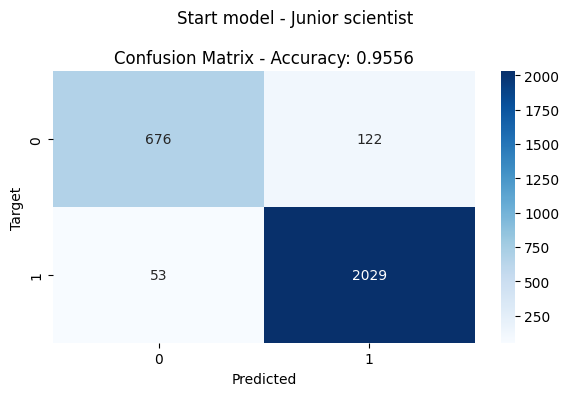

In [107]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

#plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
#plot.set(xlabel="Predicted", ylabel="Target")

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {acc:.4f}")
plt.suptitle("Start model - Junior scientist")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy.png")
plt.show()


Update model to 6 convolutional layers including Max pooling and add a dropout layer at the end.

In [108]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling added
        )
        self.dropout = nn.Dropout(p=0.25)  # Dropout layer added

    def forward(self, x):
        return self.dropout(self.conv(x))

In [109]:
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers'] - 1):  # Adjusted for 6 convolutional layers
            self.convolutions.extend([ConvBlock(hidden, hidden)])

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8 * 6) * hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Second dropout layer added
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [110]:
from src import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
config = {
    'hidden' : 16,
    'num_layers' : 6,
    'num_classes' : 2, # 5 for big dataset
    'dropout_rate': 0.25,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:24:25.326 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:24:25.327 | INFO     | src.models:__init__:38 - Input linear: 768


torch.Size([32, 2])

In [111]:
yhat = model(x)

In [112]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [113]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [114]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

 #   trainer = Trainer(
        # model=model,
        # settings=settings,
        # loss_fn=loss_fn,
        # optimizer=torch.optim.Adam,
        # traindataloader=trainstreamer.stream(),
        # validdataloader=teststreamer.stream(),
        # scheduler=None,
       # )
    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-06-29 10:24:25.545 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240629-102425
100%|██████████| 363/363 [00:05<00:00, 62.10it/s]
2024-06-29 10:24:32.489 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5998 test 0.5916 metric ['0.7233', '0.7233', '0.4184', '0.7233', '0.5000']
100%|██████████| 363/363 [00:06<00:00, 58.37it/s]
2024-06-29 10:24:39.812 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5927 test 0.5914 metric ['0.7226', '0.7226', '0.4185', '0.7226', '0.5000']
100%|██████████| 363/363 [00:08<00:00, 40.90it/s]
2024-06-29 10:24:49.793 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5924 test 0.5941 metric ['0.7240', '0.7240', '0.4187', '0.7240', '0.5000']
100%|██████████| 363/363 [00:30<00:00, 11.84it/s]
2024-06-29 10:25:21.608 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.5934 test 0.5903 metric ['0.7229', '0.7229', '0.4187', '0.7229', '0.5000']
100%|██████████| 363/363 [01:22<00:00,  4.40it/s]
2

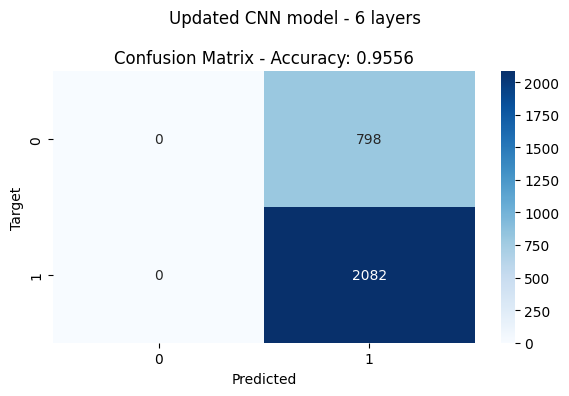

In [115]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

#plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
#plot.set(xlabel="Predicted", ylabel="Target")

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {acc:.4f}")
plt.suptitle("Updated CNN model - 6 layers")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy_2.png")
plt.show()

Change units and dropout

In [116]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),  # Batch normalization added
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling added
        )
        self.dropout = nn.Dropout(p=0.25)  # Dropout layer added

    def forward(self, x):
        return self.dropout(self.conv(x))

In [117]:
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers'] - 1):  # Adjusted for 6 convolutional layers
            self.convolutions.extend([ConvBlock(hidden, hidden)])

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8 * 6) * hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Second dropout layer added
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [118]:
from src import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
config = {
    'hidden' : 32,
    'num_layers' : 6,
    'num_classes' : 2, # 5 for big dataset
    'dropout_rate': 0.25,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-29 10:27:07.327 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-29 10:27:07.327 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 2])

In [119]:
yhat = model(x)

In [120]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [121]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718732376163, experiment_id='1', last_update_time=1718732376163, lifecycle_stage='active', name='2D conv model', tags={}>

In [122]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

 #   trainer = Trainer(
        # model=model,
        # settings=settings,
        # loss_fn=loss_fn,
        # optimizer=torch.optim.Adam,
        # traindataloader=trainstreamer.stream(),
        # validdataloader=teststreamer.stream(),
        # scheduler=None,
       # )
    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2024-06-29 10:27:07.545 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240629-102707
100%|██████████| 363/363 [00:12<00:00, 30.07it/s]
2024-06-29 10:27:21.377 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5958 test 0.5909 metric ['0.7229', '0.7229', '0.4185', '0.7229', '0.5000']
100%|██████████| 363/363 [00:12<00:00, 28.97it/s]
2024-06-29 10:27:35.423 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5923 test 0.5933 metric ['0.7215', '0.7215', '0.4180', '0.7215', '0.5000']
100%|██████████| 363/363 [00:14<00:00, 25.74it/s]
2024-06-29 10:27:51.185 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5929 test 0.5899 metric ['0.7233', '0.7233', '0.4185', '0.7233', '0.5000']
100%|██████████| 363/363 [01:14<00:00,  4.85it/s]
2024-06-29 10:29:07.940 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.5929 test 0.5901 metric ['0.7236', '0.7236', '0.4186', '0.7236', '0.5000']
100%|██████████| 363/363 [02:15<00:00,  2.67it/s]
2

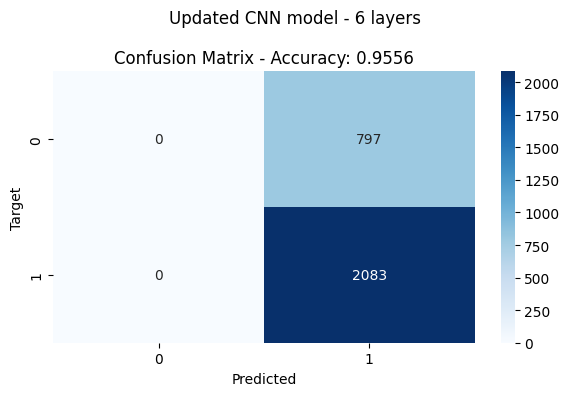

In [123]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

#plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
#plot.set(xlabel="Predicted", ylabel="Target")

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Accuracy: {acc:.4f}")
plt.suptitle("Updated CNN model - 6 layers")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.tight_layout()
plt.savefig("confusion_matrix_with_accuracy_3.png")
plt.show()